# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import warnings

%matplotlib inline

In [2]:
# ignore the various warnings when running Monte Carlo simulations
warnings.filterwarnings('ignore')

In [3]:
## MAKE SURE TO LOAD YOUR OWN ALPACA_API_KEY AND ALPACA_SECRET_KEY IN THE 'ENV.env' FILE BEFORE PROCEEDING ##

# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [6]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_price = requests.get(eth_url).json()['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = round(my_btc * btc_price,2)
my_eth_value = round(my_eth * eth_price,2)

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $36429.60
The current value of your 5.3 ETH is $10273.41


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 110

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [9]:
# Format current date as ISO format
today = pd.Timestamp("2023-07-12", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
portfolio_df = api.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df
portfolio_df

# Reorganize the DataFrame
# Separate ticker data
AGG = portfolio_df[portfolio_df['symbol']=='AGG'].drop('symbol',axis=1)
SPY = portfolio_df[portfolio_df['symbol']=='SPY'].drop('symbol',axis=1)

# Concatenate the ticker DataFrames
portfolio_df = pd.concat([AGG,SPY],axis=1,keys=['AGG','SPY'])

# Preview DataFrame
portfolio_df.head()

AGG                                             \
                            open     high    low close   volume trade_count   
timestamp                                                                     
2023-07-12 04:00:00+00:00  97.51  97.8499  97.45  97.8  7189081       23483   

                                         SPY                            \
                                vwap    open      high     low   close   
timestamp                                                                
2023-07-12 04:00:00+00:00  97.718226  446.39  447.4799  444.91  446.02   

                                                             
                             volume trade_count        vwap  
timestamp                                                    
2023-07-12 04:00:00+00:00  91949783      585806  445.659246

In [10]:
# Pick AGG and SPY close prices
agg_close_price = round(portfolio_df['AGG']['close'][0],2)
spy_close_price = round(portfolio_df['SPY']['close'][0],2)

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price:0.2f}")
print(f"Current SPY closing price: ${spy_close_price:0.2f}")

Current AGG closing price: $97.80
Current SPY closing price: $446.02


In [11]:
# Compute the current value of shares
my_agg_value = round(my_agg * agg_close_price,2)
my_spy_value = round(my_spy * spy_close_price,2)

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 110 SPY shares is $49062.20
The current value of your 200 AGG shares is $19560.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
savings_data = [round(my_btc_value + my_eth_value,2),round(my_spy_value + my_agg_value,2)]

# Create savings DataFrame
df_savings = pd.DataFrame(savings_data,index=['crypto','shares'],columns=['amount'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,46703.01
shares,68622.20


<Axes: title={'center': 'Composition of personal savings'}, ylabel='amount'>

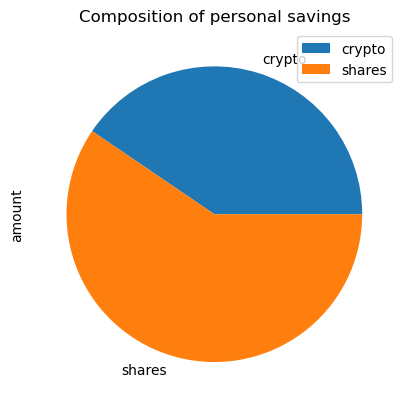

In [13]:
# Plot savings pie chart
df_savings.plot.pie(y='amount',title='Composition of personal savings')

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'].sum()

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations! You have enough money in your emergency fund.')
elif total_savings == emergency_fund:
    print('Congratulations! You have reached an important financial goal.')
else:
    print(f'You are ${round(emergency_fund-total_savings,2)} away from reaching your emergency savings goal.')

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2018-07-12', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2023-07-12', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol',axis=1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol',axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG,SPY],axis=1,keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()

AGG                                      \
                             open     high       low   close   volume   
timestamp                                                               
2018-07-12 04:00:00+00:00  106.26  106.420  106.2600  106.41  2145797   
2018-07-13 04:00:00+00:00  106.44  106.520  106.4400  106.51  2235587   
2018-07-16 04:00:00+00:00  106.35  106.400  106.2434  106.39  2116689   
2018-07-17 04:00:00+00:00  106.40  106.450  106.2900  106.35  2964110   
2018-07-18 04:00:00+00:00  106.36  106.385  106.2700  106.32  1760878   

                                                      SPY                   \
                          trade_count        vwap    open     high     low   
timestamp                                                                    
2018-07-12 04:00:00+00:00        8401  106.365689  278.28  279.430  277.60   
2018-07-13 04:00:00+00:00        9524  106.486794  279.17  279.930  278.66   
2018-07-16 04:00:00+00:00        8807  106.343343  279.64  279.803  278.84   
2018-07-17 04:00:00+00:00       10450  106.371231  278.47  280.910  278.41   
2018-07-18 04:00:00+00:00       14103  106.336028  280.56  281.180  280.06   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2018-07-12 04:00:00+00:00  279.29  60185206      236263  278.725115  
2018-07-13 04:00:00+00:00  279.56  48259487      206152  279.527779  
2018-07-16 04:00:00+00:00  279.39  48722138      177350  279.312325  
2018-07-17 04:00:00+00:00  280.43  52890500      216883  280.027102  
2018-07-18 04:00:00+00:00  281.06  45335061      169756  280.805105

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_dist = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[.4,.6],
    num_simulation=500,
    num_trading_days=252*30
)

In [18]:
# Printing the simulation input data
MC_dist.portfolio_data.head()

AGG                                      \
                             open     high       low   close   volume   
timestamp                                                               
2018-07-12 04:00:00+00:00  106.26  106.420  106.2600  106.41  2145797   
2018-07-13 04:00:00+00:00  106.44  106.520  106.4400  106.51  2235587   
2018-07-16 04:00:00+00:00  106.35  106.400  106.2434  106.39  2116689   
2018-07-17 04:00:00+00:00  106.40  106.450  106.2900  106.35  2964110   
2018-07-18 04:00:00+00:00  106.36  106.385  106.2700  106.32  1760878   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2018-07-12 04:00:00+00:00        8401  106.365689          NaN  278.28   
2018-07-13 04:00:00+00:00        9524  106.486794     0.000940  279.17   
2018-07-16 04:00:00+00:00        8807  106.343343    -0.001127  279.64   
2018-07-17 04:00:00+00:00       10450  106.371231    -0.000376  278.47   
2018-07-18 04:00:00+00:00       14103  106.336028    -0.000282  280.56   

                                                                          \
                              high     low   close    volume trade_count   
timestamp                                                                  
2018-07-12 04:00:00+00:00  279.430  277.60  279.29  60185206      236263   
2018-07-13 04:00:00+00:00  279.930  278.66  279.56  48259487      206152   
2018-07-16 04:00:00+00:00  279.803  278.84  279.39  48722138      177350   
2018-07-17 04:00:00+00:00  280.910  278.41  280.43  52890500      216883   
2018-07-18 04:00:00+00:00  281.180  280.06  281.06  45335061      169756   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-07-12 04:00:00+00:00  278.725115          NaN  
2018-07-13 04:00:00+00:00  279.527779     0.000967  
2018-07-16 04:00:00+00:00  279.312325    -0.000608  
2018-07-17 04:00:00+00:00  280.027102     0.003722  
2018-07-18 04:00:00+00:00  280.805105     0.002247

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009597,1.005734,1.008857,0.999138,0.992094,1.013929,0.989390,1.008357,0.999603,1.007099,...,0.999772,1.000945,1.009661,1.000098,0.986997,1.008813,0.987398,1.007804,1.003386,1.007436
2,1.003209,1.008020,1.003507,1.006929,0.996128,1.002038,0.989800,1.006392,1.001741,0.997870,...,1.012808,1.007534,1.014979,0.989319,1.000213,1.002422,1.000113,0.998979,1.000366,1.009282
3,1.012390,1.010387,1.005890,0.991449,0.994151,0.992541,0.987788,1.004797,1.003218,0.983985,...,1.004265,1.009895,1.029563,1.000214,1.003541,0.999855,0.998796,0.997519,1.010637,1.012701
4,1.031136,0.998308,1.019844,1.007763,0.989672,0.982786,0.989005,0.994413,0.998807,0.984979,...,1.001352,1.007776,1.047218,1.000544,1.002721,1.015213,0.987275,0.980091,1.011831,1.023960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,9.528531,2.868016,7.907670,9.281701,2.513527,11.912078,3.578408,2.823401,6.720482,3.375230,...,6.314488,12.741282,3.213696,9.053549,2.979154,2.962124,37.756752,3.137133,12.359613,2.812268
7557,9.515657,2.887861,7.891974,9.271419,2.492018,11.689097,3.579612,2.889453,6.727833,3.377156,...,6.256540,12.740027,3.216094,9.044619,2.962559,3.030950,38.055288,3.135552,12.238909,2.779646
7558,9.501118,2.921415,7.998545,9.263177,2.485127,11.584742,3.610728,2.898565,6.772943,3.369088,...,6.231043,12.775707,3.209707,8.961200,2.936154,3.010277,38.427459,3.111978,12.193627,2.781677
7559,9.512138,2.879611,7.924049,9.299539,2.512306,11.690766,3.640935,2.888679,6.762338,3.323960,...,6.201628,12.790187,3.247576,9.019778,2.961945,3.022536,37.927682,3.161299,12.140502,2.778118


<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

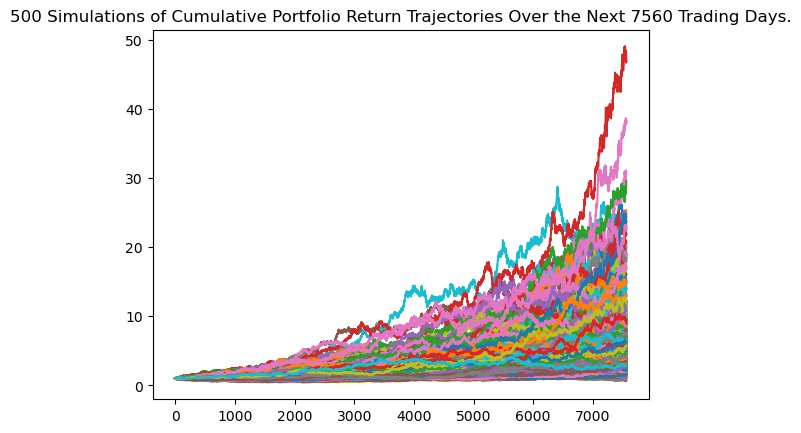

In [20]:
# Plot simulation outcomes
MC_dist.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

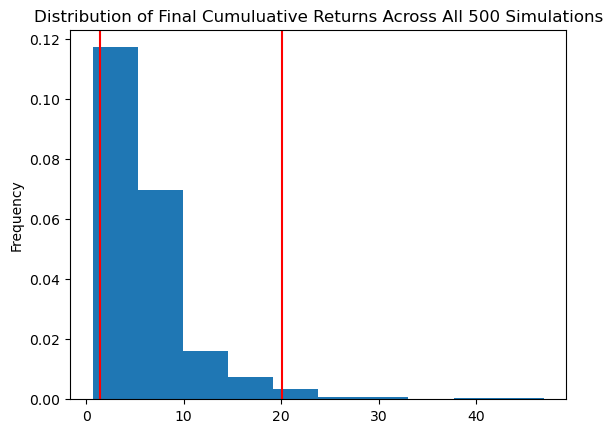

In [21]:
# Plot probability distribution and confidence intervals
MC_dist.plot_distribution()

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_stats = MC_dist.summarize_cumulative_return()

# Print summary statistics
print(MC_stats)

count           500.000000
mean              6.259857
std               5.065047
min               0.670857
25%               2.998459
50%               4.959099
75%               7.612135
max              46.963075
95% CI Lower      1.378887
95% CI Upper     20.048470
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = round(20000,2)

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(initial_investment * MC_stats[8],2)
ci_upper = round(initial_investment * MC_stats[9],2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $27577.75 and $400969.39


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [24]:
# Set initial investment
initial_investment = round(20000 * 1.5,2)

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(initial_investment * MC_stats[8],2)
ci_upper = round(initial_investment * MC_stats[9],2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $41366.62 and $601454.09


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5y_dist = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[.2,.8],
    num_simulation=500,
    num_trading_days=252*5
)

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5y_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991658,0.999362,0.998918,1.019023,1.000221,1.007248,1.008734,1.009893,0.987913,0.997656,...,0.992570,1.001708,1.018807,1.013928,1.013818,1.003785,0.982370,0.999700,1.003181,0.995194
2,1.000235,1.004211,1.007333,1.028911,1.015018,0.991916,1.004307,1.004300,0.990792,0.996730,...,1.006740,1.001140,1.033831,1.031660,0.990102,1.004966,0.987265,0.996733,1.011363,1.006972
3,0.990445,0.998137,1.014256,1.026297,1.007550,1.001017,0.995409,1.000679,0.998343,0.975393,...,1.002144,1.011250,1.025412,1.024210,0.991923,1.012426,0.976780,0.969127,1.021683,1.005747
4,0.995932,1.004657,1.019271,1.035651,1.030508,0.987136,0.999094,0.995441,0.995890,0.955404,...,1.003414,1.018935,1.028032,1.018345,0.991249,1.020588,0.969035,0.959409,1.014459,1.003587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.511248,1.073335,1.228865,2.625096,2.198391,1.279689,2.021474,1.343969,3.431217,1.033434,...,0.984807,1.091947,1.229975,1.557899,0.969147,1.451203,1.825599,1.202815,1.678656,1.474386
1257,1.519250,1.083483,1.218414,2.687255,2.197185,1.289096,2.032357,1.338838,3.520956,1.039680,...,0.983612,1.083350,1.221854,1.580659,0.948725,1.487507,1.850184,1.190899,1.696886,1.469723
1258,1.538932,1.070881,1.216382,2.649580,2.221878,1.267980,2.015081,1.326113,3.548079,1.045532,...,0.995838,1.075797,1.192442,1.567703,0.958810,1.489221,1.858185,1.163180,1.679864,1.446986
1259,1.531688,1.078919,1.215321,2.609858,2.190755,1.265937,2.026992,1.330893,3.559966,1.056728,...,1.008949,1.074604,1.193651,1.571578,0.958758,1.490810,1.849647,1.156887,1.693232,1.452090


<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

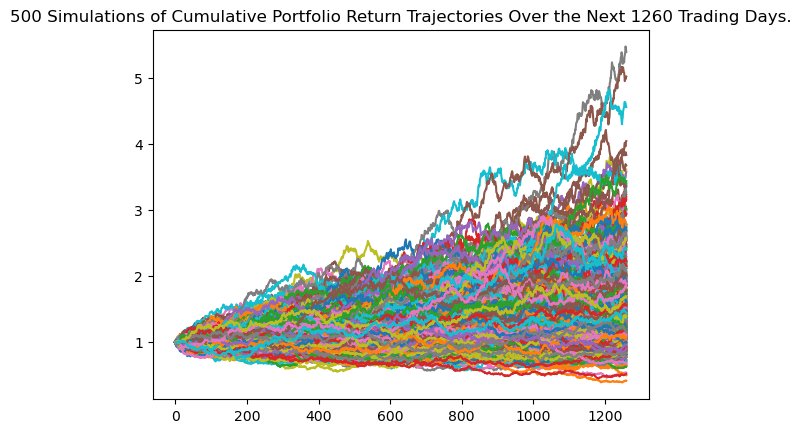

In [27]:
# Plot simulation outcomes
MC_5y_dist.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

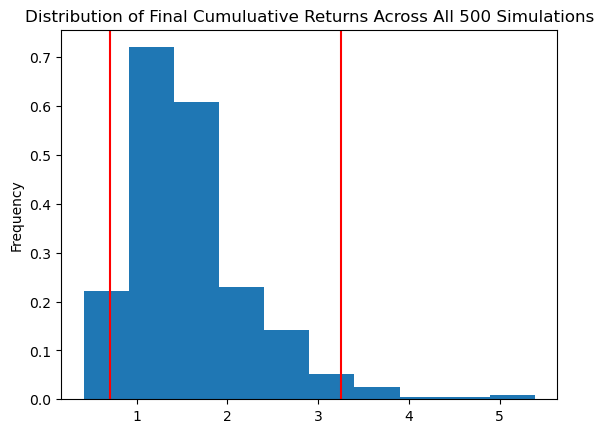

In [28]:
# Plot probability distribution and confidence intervals
MC_5y_dist.plot_distribution()

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_5y_stats = MC_5y_dist.summarize_cumulative_return()

# Print summary statistics
print(MC_5y_stats)

count           500.000000
mean              1.584936
std               0.664122
min               0.419707
25%               1.135335
50%               1.449405
75%               1.869041
max               5.388807
95% CI Lower      0.702983
95% CI Upper      3.252397
Name: 1260, dtype: float64


In [30]:
# Set initial investment
initial_investment = round(60000,2)

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(initial_investment * MC_5y_stats[8],2)
ci_upper_five = round(initial_investment * MC_5y_stats[9],2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $42178.96 and $195143.82


### Ten Years Retirement Option

In [31]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10y_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.2,.8],
    num_simulation=500,
    num_trading_days=252*10
)

In [32]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10y_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009839,1.017600,0.993268,0.994502,0.995748,1.001786,1.005748,1.013624,0.996701,1.004992,...,0.994298,1.011366,0.993288,1.015725,1.008610,1.002028,0.992997,1.003078,1.006363,0.997233
2,1.029436,1.006875,0.995876,0.996443,0.978667,0.989217,1.004273,1.034566,0.996720,0.999176,...,1.013084,1.014971,1.007091,1.028016,1.018144,1.010361,0.987420,0.998916,1.006106,0.998362
3,1.031067,1.001319,0.988878,1.006596,0.978397,0.993824,1.010251,1.026618,0.998369,1.002327,...,1.009174,1.016399,1.016962,1.031685,1.038658,0.994463,0.993055,0.995527,1.002337,0.996191
4,1.048425,1.014115,0.993597,0.998726,0.981584,0.986283,1.014571,1.022778,1.005582,1.016483,...,1.006823,1.021407,1.025654,1.039125,1.028686,0.997746,1.007750,1.004910,1.009133,0.993496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.032843,5.063876,2.200228,2.114181,2.184249,2.220942,3.823464,1.062217,10.984842,0.780136,...,1.594574,2.082713,3.039705,1.472805,2.081335,2.549624,2.893741,2.285794,4.220718,1.909445
2517,2.030835,5.128029,2.214392,2.095084,2.209615,2.262502,3.815512,1.058254,10.978665,0.777010,...,1.632967,2.074225,3.040603,1.471900,2.085586,2.572134,2.912351,2.297821,4.223865,1.933778
2518,2.023195,5.092541,2.202184,2.108671,2.198504,2.241199,3.857001,1.059057,10.980312,0.791915,...,1.628483,2.072583,3.056965,1.479215,2.114476,2.577528,2.917874,2.325447,4.222607,1.937108
2519,2.017807,5.016550,2.253623,2.104577,2.191644,2.220425,3.862847,1.052376,10.949736,0.790091,...,1.609014,2.102825,3.055711,1.462185,2.102922,2.595115,2.884868,2.327110,4.244856,1.893907


<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

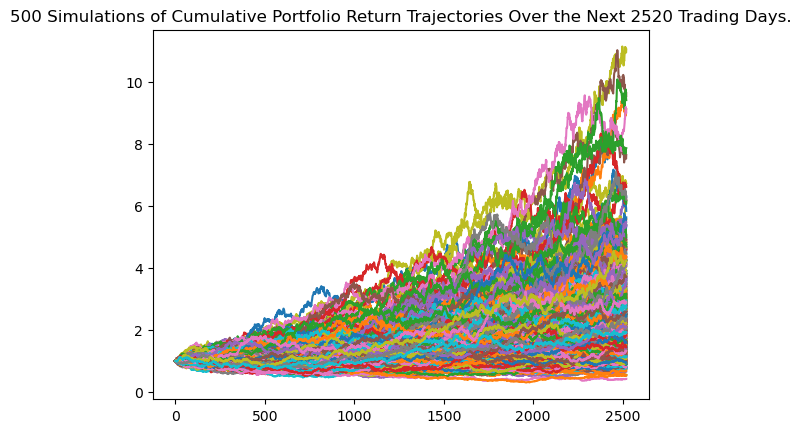

In [33]:
# Plot simulation outcomes
MC_10y_dist.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

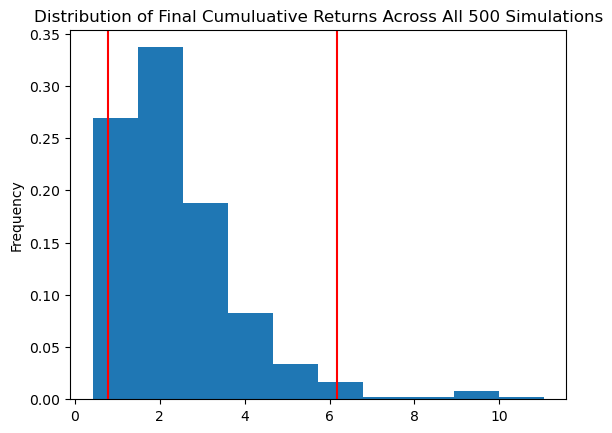

In [34]:
# Plot probability distribution and confidence intervals
MC_10y_dist.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_10y_stats = MC_10y_dist.summarize_cumulative_return()

# Print summary statistics
print(MC_10y_stats)

count           500.000000
mean              2.415432
std               1.436305
min               0.421636
25%               1.410628
50%               2.101993
75%               2.963555
max              11.048623
95% CI Lower      0.787433
95% CI Upper      6.174520
Name: 2520, dtype: float64


In [36]:
# Set initial investment
initial_investment = round(60000,2)

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(initial_investment * MC_10y_stats[8],2)
ci_upper_ten = round(initial_investment * MC_10y_stats[9],2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $47245.98 and $370471.2
